Key Assumption:
The volatility between price show how the market feels - and might help us guess what happens next and do a decision.

Hypothesus: Volatility patterns from candlestick data (range, continuation, and shadow size) reflect market behaviour, and can be used to anticipate breakouts, continuations or reversals.

In [53]:
!pip install cybotrade_datasource
!pip install python-dotenv
!pip install hmmlearn
!pip install bt

import pandas as pd
import numpy as np
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from hmmlearn.hmm import GaussianHMM
import bt 


import warnings as wr
wr.filterwarnings('ignore')

print(dir(cybotrade_datasource))

load_dotenv()

API_KEY = os.getenv('CYBOTRADE_API_KEY')


global_df = None 

async def get_data(topic):
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic=topic, 
        limit=10000
    )
    return pd.DataFrame(data)


async def main():
    global global_df

    topics = [
        "bybit-linear|candle?symbol=BTCUSDT&interval=1m",
    ]

#topic
#"cryptoquant|btc/market-data/open-interest?exchange=bybit&window=min",
#bybit-linear|candle?interval=1m&symbol=BTCUSDT
#"cryptoquant|btc/market-data/coinbase-premium-index?window=hour",
#"cryptoquant|btc/exchange-flows/outflow?exchange=coinbase_advanced&window=hour",
#"glassnode|market/deltacap_usd?a=BTC&i=10m",

    tasks = [get_data(topic) for topic in topics]
    dataframes = await asyncio.gather(*tasks)

    for i, df in enumerate(dataframes):
        print(f"DataFrame {i+1} ({topics[i]})")
        print(df.head)
        print(df.isnull().sum())
        global_df = df

await main()


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cybotrade_datasource', 'query', 'query_paginated', 'stream']
DataFrame 1 (bybit-linear|candle?symbol=BTCUSDT&interval=1m)
<bound method NDFrame.head of          start_time    close     high      low     open   volume
0     1743794700000  84342.2  84426.8  84342.1  84390.0  118.343
1     1743794760000  84197.4  84407.7  84181.3  84342.2   64.779
2     1743794820000  84270.0  84279.7  84145.5  84197.4   48.658
3     1743794880000  84260.7  84279.9  84211.4  84270.0   43.407
4     1743794940000  84209.0  84260.7  84182.3  84260.7   28.762
...             ...      ...      ...      ...      ...      ...
9995  1744394400000  83860.0  83943.0  83807.8  83906.0   93.585
9996  1744394460000  83893.8  83893.9  83800.0  83860.0   90.450
9997  1744394520000  83970.0  83976.1  83876.0  83893.8   73.807
9998  1744394580000  84023.9  84023.9  83918.3  83970.0  138.904
9999  1744394

In [54]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-04 19:25:00
1    2025-04-04 19:26:00
2    2025-04-04 19:27:00
3    2025-04-04 19:28:00
4    2025-04-04 19:29:00
...                  ...
9995 2025-04-11 18:00:00
9996 2025-04-11 18:01:00
9997 2025-04-11 18:02:00
9998 2025-04-11 18:03:00
9999 2025-04-11 18:04:00

[10000 rows x 1 columns]


1. Set data interval = 1 day

...
import pandas as pd
from datetime import datetime

# Convert timestamp if needed (assumes milliseconds)
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')

# Get today's date (in your timezone)
today = pd.to_datetime(datetime.now()).normalize()

# Filter only rows that match today's date
global_df = global_df[global_df['start_time'].dt.normalize() == today]

# Optional: Reset index after filtering
global_df = global_df.reset_index(drop=True)

# Check result
print("Data filtered for:", today.date())
print(global_df.head())
...

2. Define signal score (range volume + volume cluster) - wick ratio

In [55]:
#Range value
global_df['RangeVol'] = global_df['high'] - global_df['low']
#Volume Cluster
global_df['VolCluster'] = global_df['close'].rolling(window=10).std()
epsilon = 1e-6
#Wick Ratio
global_df['wick_ratio'] = (
    (global_df['high'] - global_df[['open', 'close']].max(axis=1)) +
    (global_df[['open', 'close']].min(axis=1) - global_df['low'])
) / (global_df['high'] - global_df['low'] + epsilon)


# Combine 
global_df['signal_score'] = global_df['RangeVol'] + global_df['VolCluster'] - global_df['wick_ratio']

In [56]:
global_df.head()

,start_time,close,high,low,open,volume,RangeVol,VolCluster,wick_ratio,signal_score
0,2025-04-04 19:25:00,84342.2,84426.8,84342.1,84390.0,118.343,84.7,NaN,0.435655,NaN
1,2025-04-04 19:26:00,84197.4,84407.7,84181.3,84342.2,64.779,226.4,NaN,0.360424,NaN
2,2025-04-04 19:27:00,84270.0,84279.7,84145.5,84197.4,48.658,134.2,NaN,0.459016,NaN
3,2025-04-04 19:28:00,84260.7,84279.9,84211.4,84270.0,43.407,68.5,NaN,0.864234,NaN
4,2025-04-04 19:29:00,84209.0,84260.7,84182.3,84260.7,28.762,78.4,NaN,0.340561,NaN


3.Define X variables

In [57]:

global_df = global_df.dropna(subset=['VolCluster']).reset_index(drop=True)

X = global_df[['signal_score']].values
print(global_df['signal_score'])



0       176.240407
1       260.544134
2       246.441362
3       223.984762
4       226.294946
           ...    
9986    171.732567
9987    129.914502
9988    138.772649
9989    161.599866
9990    163.183951
Name: signal_score, Length: 9991, dtype: float64


In [58]:
print("NaNs in RangeVol:", global_df['RangeVol'].isna().sum())
print("NaNs in VolCluster:", global_df['VolCluster'].isna().sum())
print("NaNs in wick_ratio:", global_df['wick_ratio'].isna().sum())

NaNs in RangeVol: 0
NaNs in VolCluster: 0
NaNs in wick_ratio: 0


In [59]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]

Define HMM Model

In [60]:
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=100, random_state=42)
model.fit(X_train)

GaussianHMM(covariance_type='full', n_components=3, n_iter=100, random_state=42)

Predict

In [61]:
global_df['state'] = model.predict(X)

Visualize Hidden States

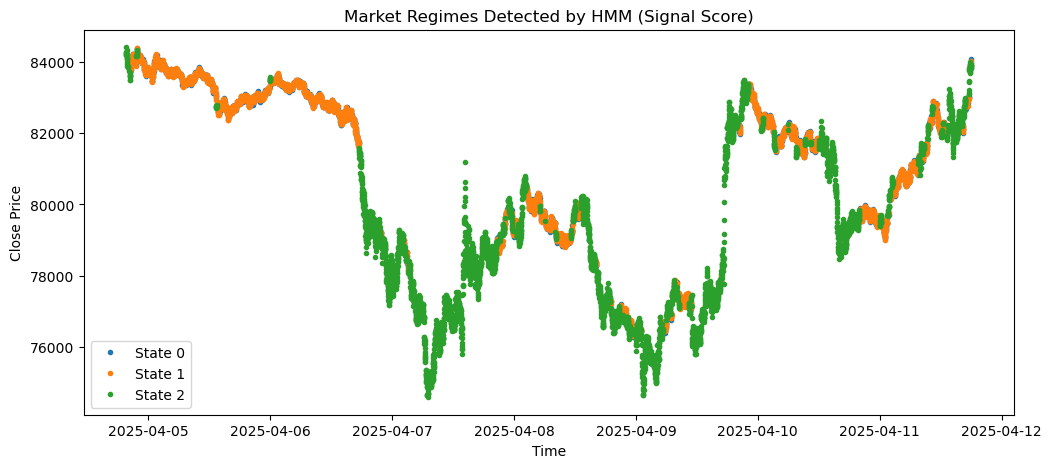

In [62]:
plt.figure(figsize=(12, 5))
for state in range(model.n_components):
    plt.plot(global_df['start_time'][global_df['state'] == state], global_df['close'][global_df['state'] == state], '.', label=f'State {state}')
plt.legend()
plt.title("Market Regimes Detected by HMM (Signal Score)")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

Generate Trading signals based on Hidden States

In [63]:
# Find which state has higher average signal score
state_means = model.means_.flatten()
low_vol_state = np.argmin(state_means)
high_vol_state = np.argmax(state_means)

# Generate signals
global_df['signal'] = np.where(global_df['state'] == low_vol_state, 1, 0)  # Buy = 1, Hold/Sell = 0

Calculate Strategy Return

In [64]:
global_df['return'] = global_df['close'].pct_change()
global_df['strategy_return'] = global_df['signal'].shift(1) * global_df['return']

# Apply trading fees only when switching positions
fee = 0.0006  # 0.06%
global_df['trade_occurred'] = global_df['signal'].diff().fillna(0) != 0
global_df['strategy_return_net'] = np.where(global_df['trade_occurred'], global_df['strategy_return'] - fee, global_df['strategy_return'])

Plot Strategy Performance

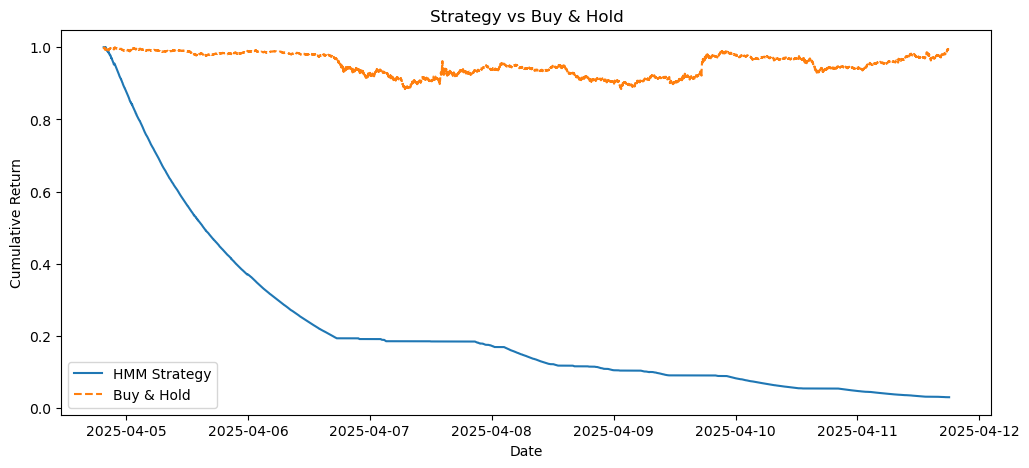

In [65]:
cumulative = (1 + global_df['strategy_return_net']).cumprod()
buy_hold = (1 + global_df['return']).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(global_df['start_time'], cumulative, label='HMM Strategy')
plt.plot(global_df['start_time'], buy_hold, label='Buy & Hold', linestyle='--')
plt.title('Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

Evaluate metrics

In [66]:
sharpe = global_df['strategy_return_net'].mean() / global_df['strategy_return_net'].std() * np.sqrt(252)
cumulative_return = cumulative.iloc[-1] - 1
drawdown = cumulative / cumulative.cummax() - 1
max_dd = drawdown.min()
trade_freq = (global_df['signal'].diff() != 0).sum() / len(global_df)

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Total Return: {cumulative_return:.2%}")
print(f"Max Drawdown: {max_dd:.2%}")
print(f"Trade Frequency: {trade_freq:.2%}")

Sharpe Ratio: -12.83
Total Return: -96.93%
Max Drawdown: -96.93%
Trade Frequency: 58.16%


In [73]:
def HMM_SIGNAL():
    return global_df['hmm_signal_backtest']

class HMMStrat(Strategy):
    def init(self):
        self.signal = self.I(HMM_SIGNAL)

    def next(self):
        if self.signal[-1] == 2:
            sl1 = self.data.Close[-1] - 750e-4
            tp1 = self.data.Close[-1] + 600e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal[-1] == 1:
            sl1 = self.data.Close[-1] + 750e-4
            tp1 = self.data.Close[-1] - 600e-4
            self.sell(sl=sl1, tp=tp1)


In [75]:
# After HMM prediction
global_df['hmm_signal'] = np.where(global_df['state'] == low_vol_state, 1, 0)

# Remap to fit backtesting.py expectations (2=Buy, 1=Sell, 0=Hold)
global_df['hmm_signal_backtest'] = np.where(global_df['hmm_signal'] == 1, 2, 0)


In [76]:
print(global_df[['hmm_signal', 'hmm_signal_backtest']].head())


   hmm_signal  hmm_signal_backtest
0           0                    0
1           0                    0
2           0                    0
3           0                    0
4           0                    0


In [77]:
def HMM_SIGNAL():
    return global_df['hmm_signal_backtest']

In [78]:
from backtesting import Strategy

class HMMStrat(Strategy):
    def init(self):
        self.signal = self.I(HMM_SIGNAL)  # No () here!

    def next(self):
        if self.signal[-1] == 2:
            sl1 = self.data.Close[-1] - 750e-4
            tp1 = self.data.Close[-1] + 600e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal[-1] == 1:
            sl1 = self.data.Close[-1] + 750e-4
            tp1 = self.data.Close[-1] - 600e-4
            self.sell(sl=sl1, tp=tp1)


In [79]:
global_df_bt = global_df.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close'
})

bt_hmm = Backtest(global_df_bt, HMMStrat, cash=10000, commission=0.002)
stats = bt_hmm.run()
print(stats)
bt_hmm.plot()


Backtest.run:   0%|          | 0/9990 [00:00<?, ?bar/s]

Start                                     0.0
End                                    9990.0
Duration                               9990.0
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                -0.38843
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                  0.0
Win Rate [%]                              NaN
Best Trade [%]                    

GridPlot(id='p1410', ...)